Load necessary libraries

In [100]:
using Plots
using ColorSchemes


In [2]:
ENV["JULIA_DEBUG"] = Main #"none" #Main #"all" #"Gen,Main"

Main

In [3]:
using Gen
using Statistics
using StatsBase
#using ProfileView #Make sure this is loaded before PyPlot to avoid stupid gtk version issues
using Profile
#using PyPlot

include("DistributionsBacked.jl")
include("IterDeep.jl")
#include("AnimatedPyplot.jl")

useNuts = false
if useNuts
    include("nuts.jl")
else   
    transform_log(args...) = throw("unimplemented")
    disable_sample_logging(args...) = print(args...)
end

includeTestingFunc = true
if includeTestingFunc
    include("testUnrealizedNormals.jl")
else
    include("unrealizedNormals.jl")
end



In [4]:
@debug "Can you see this"

┌ Debug: Can you see this
└ @ Main In[4]:1


Space for declaring constants.

In [5]:
const my_inv_gamma = DistributionsBacked{Float64}((alpha, theta) -> Distributions.InverseGamma(alpha, theta), [true, true], true)
const my_lognormal = DistributionsBacked{Float64}((mu, sig) -> Distributions.LogNormal(mu, sig), [true, true], true)

disable_sample_logging()
INV_GAMMA_PRIOR_CONSTANT = 0.1;

Canonical Rats data, from from section 6 of Gelfand et al (1990). See http://www.openbugs.net/Examples/Rats.html

In [6]:
ys_raw = ([151, 145, 147, 155, 135, 159, 141, 159, 177, 134,
    160, 143, 154, 171, 163, 160, 142, 156, 157, 152, 154, 139, 146,
    157, 132, 160, 169, 157, 137, 153, 199, 199, 214, 200, 188, 210,
    189, 201, 236, 182, 208, 188, 200, 221, 216, 207, 187, 203, 212,
    203, 205, 190, 191, 211, 185, 207, 216, 205, 180, 200, 246, 249,
    263, 237, 230, 252, 231, 248, 285, 220, 261, 220, 244, 270, 242,
    248, 234, 243, 259, 246, 253, 225, 229, 250, 237, 257, 261, 248,
    219, 244, 283, 293, 312, 272, 280, 298, 275, 297, 350, 260, 313,
    273, 289, 326, 281, 288, 280, 283, 307, 286, 298, 267, 272, 285,
    286, 303, 295, 289, 258, 286, 320, 354, 328, 297, 323, 331, 305,
    338, 376, 296, 352, 314, 325, 358, 312, 324, 316, 317, 336, 321,
    334, 302, 302, 323, 331, 345, 333, 316, 291, 324])
ys = reshape([Float64(y) for y = ys_raw],30,5)
xs = [8.0, 15.0, 22.0, 29.0, 36.0]
xbar = mean(xs)
xcs = xs .- xbar
ys = ys ./ 100.
#ys = ys[1:2,:]

(N,T) = size(ys)
;

These data are the weights of 30 rats, measured at 5 common age values in days. The model is a simple hierarchical/random effects one; a random intercept and random slope for each rat, plus an error term (presumably representing not measurement error, but just the random variation of individual growth curves).

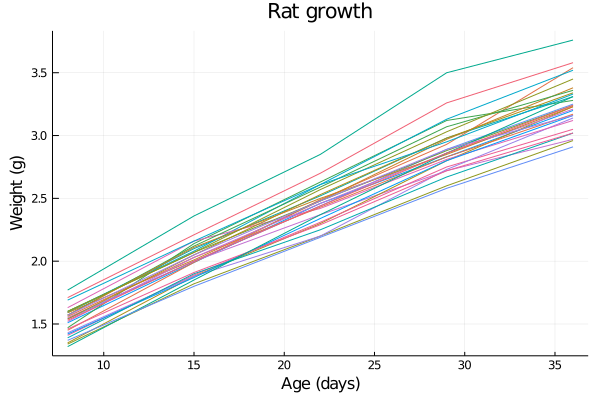

In [7]:
plot(xs,
    transpose(ys),
    xlabel="Age (days)",
    ylabel = "Weight (g)",
    title="Rat growth",
    legend=false)

In [8]:
function make_constraints(ys::Array)
    (N,T) = size(ys)
    constraints = Gen.choicemap()
    for n in 1:N
        for (t, y) in enumerate(ys[n,:])
            constraints[:data => n => "y$(t)"] = y
        end
    end
    constraints
end
;

In [9]:
function mcmc_inference(xs, observations, num_iters, update, model = ratsModel)
    results = Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}(undef, num_iters+1)
    N = size(ys)[1]
    (trace, _) = generate(model, (xs, N), observations)
    results[1] = trace
    selection = Gen.complement(select(observations))
    for iter=1:num_iters
        trace = update(trace,N,selection)
        results[iter+1] = trace
    end
    results
end
;

In [10]:

        
        
@gen function oneDeferredRat(xs_centered, T, mu_alpha, sigmasq_alpha, mu_beta, sigmasq_beta, sigmasq_y)

    #@warn "oneDeferredRat" T
    alpha ~ unrealizedIndyNormal(mu_alpha, sqrt(sigmasq_alpha))
    beta ~ unrealizedIndyNormal(mu_beta, sqrt(sigmasq_beta))
    for t = 1:T
        #@warn "before"
        @trace(observedNormal(alpha + beta * (xs_centered[t]), sqrt(sigmasq_y)), "y$(t)")
        #@warn "after" 
    end
end


@gen function deferredRatsModel(xs::Vector,N::Int64,)
    T = length(xs)
    xbar = mean(xs) #could be precomputed, but YKWTS about premature optimization...

    mu_alpha ~ normal(0, 10.0)
    mu_beta ~ normal(0, 1.0)
    sigmasq_y ~ my_inv_gamma(INV_GAMMA_PRIOR_CONSTANT, INV_GAMMA_PRIOR_CONSTANT)
    sigmasq_alpha ~ my_inv_gamma(INV_GAMMA_PRIOR_CONSTANT, INV_GAMMA_PRIOR_CONSTANT)
    sigmasq_beta ~ my_inv_gamma(INV_GAMMA_PRIOR_CONSTANT, INV_GAMMA_PRIOR_CONSTANT)

    alpha = Vector{Float64}(undef,N)
    beta = Vector{Float64}(undef,N)
    y = Vector{Vector{Float64}}(undef,N)
    for n in 1:N
        {:data => n} ~ oneDeferredRat(xs .- xbar, T, mu_alpha, sigmasq_alpha, mu_beta, sigmasq_beta, sigmasq_y)
    end
end

model_transformations = choicemap()
model_transformations[:sigmasq_y] = transform_log
model_transformations[:sigmasq_alpha] = transform_log
model_transformations[:sigmasq_beta] = transform_log

;

In [11]:


function plotRats(cm,#choicemap
        xs=xs)
    plot(xs,
        [[cm[:data => n => "y$(t)"] for t in 1:T] for n in 1:N],
        alpha=1.,
        ylabel="Weight (g)",
        title="Rat growth",
        xlabel="Age (days)",
        leg=false)

end



plotRats (generic function with 2 methods)

In [12]:
function printKeyVals(tr)
    print("mu_alpha: $(tr[:mu_alpha]), mu_beta: $(tr[:mu_beta])\n" *
        "sigma_y: $(sqrt(tr[:sigmasq_y])), sigma_α: $(sqrt(tr[:sigmasq_alpha])),"*
        " sigma_β: $(sqrt(tr[:sigmasq_beta]))\n")
end
;

Let's make sure simulating from this model gives "reasonable"-looking output:

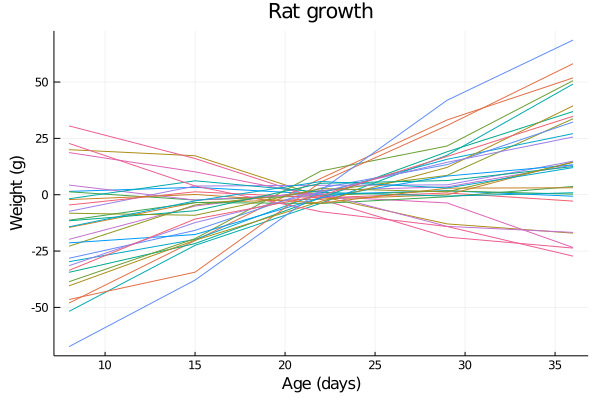

In [13]:
(N,T) = size(ys)
smallvars = choicemap()
smallvars[:sigmasq_y] = 16.
smallvars[:sigmasq_alpha] = 9.
smallvars[:sigmasq_beta] = 4.
t,_ = generate(deferredRatsModel, (xs, N), smallvars)
cm = get_choices(t)

#[[cm[:data => n => "y$(t)"] for t in 1:T] for n in 1:N]
plotRats(cm)


In [14]:
@gen function oneRat(xs, T, mu_alpha, sigmasq_alpha, mu_beta, sigmasq_beta, sigmasq_y)

    alpha ~ normal(mu_alpha, sqrt(sigmasq_alpha))
    beta ~ normal(mu_beta, sqrt(sigmasq_beta))
    
    for t = 1:T
        @trace(normal(alpha + beta * (xs[t]), sqrt(sigmasq_y)), "y$(t)")
    end
end

@gen function ratsModel(xs::Vector,N::Int64,)
    T = length(xs)
    xbar = mean(xs) #could be precomputed, but YKWTS about premature optimization...

    mu_alpha ~ normal(0, 10.0)
    mu_beta ~ normal(0, 1.0)
    sigmasq_y ~ my_inv_gamma(INV_GAMMA_PRIOR_CONSTANT, INV_GAMMA_PRIOR_CONSTANT)
    sigmasq_alpha ~ my_inv_gamma(INV_GAMMA_PRIOR_CONSTANT, INV_GAMMA_PRIOR_CONSTANT)
    sigmasq_beta ~ my_inv_gamma(INV_GAMMA_PRIOR_CONSTANT, INV_GAMMA_PRIOR_CONSTANT)

    alpha = Vector{Float64}(undef,N)
    beta = Vector{Float64}(undef,N)
    y = Vector{Vector{Float64}}(undef,N)
    for n in 1:N
        {:data => n} ~ oneRat(xs .- xbar, T, mu_alpha, sigmasq_alpha, mu_beta, sigmasq_beta, sigmasq_y)
    end
end

model_transformations = choicemap()
model_transformations[:sigmasq_y] = transform_log
model_transformations[:sigmasq_alpha] = transform_log
model_transformations[:sigmasq_beta] = transform_log

;

In [15]:
4+1

5

In [80]:
c = make_constraints(ys)
alphahats = mean(ys,dims=2)
alphahat = mean(alphahats)
betahats = [xcs\ys[r,:] for r in 1:N]
betahat = mean(betahats)
c[:mu_alpha] = alphahat + 0.0
c[:mu_beta] = betahat - 0.0

c[:sigmasq_beta] = var(betahats) #* 2.1603 #is better???
c[:sigmasq_alpha] = var(alphahats) #* 20.
c[:sigmasq_y] = var(transpose(xcs) .* betahat .+ alphahats .- ys)#, corrected=false)

meanDrifts = choicemap()
meanDrifts[:mu_alpha] = std(alphahats) #/ sqrt(N) 
meanDrifts[:mu_beta] = std(betahats) #/ sqrt(N) 

@gen function proposeDrift(tr, scales, tuner)
    for (k, σ) in iter_deep(scales)
        @trace(normal(tr[k],σ/tuner),k)
    end
end


sigmaDrifts = choicemap()
sigmaDrifts[:sigmasq_alpha] = .5
sigmaDrifts[:sigmasq_beta] = .5
sigmaDrifts[:sigmasq_y] = .5

@gen function proposeDriftPositive(tr, scales, tuner)
    for (k, σ) in iter_deep(scales)
        @trace(my_lognormal(log(tr[k]),σ/tuner),k)
    end
end

function block_mh_drift_just_mus(tr,N,selection)
    meanTuner = rand() < 0.05 ? 0.1 : 0.7 #occasionally attempt big moves — don't get stuck.
    #meanTuner = 0.7
    (tr, _) = mh(tr, proposeDrift, (meanDrifts,meanTuner))

    tr
end


function block_mh_d(tr,N,selection)
    meanTuner = rand() < 0.05 ? 0.01 : 0.7 #occasionally attempt big moves — don't get stuck.
    (tr, _) = mh(tr, proposeDrift, (meanDrifts,meanTuner))
    (tr, _) = mh(tr, proposeDriftPositive, (sigmaDrifts,1.))

    tr
end

function block_mh_resim_just_mus(tr,N,selection)
    (tr, _) = mh(tr, select(:mu_alpha, :mu_beta))

    tr
end

function block_mh_resim_mus_latents(tr,N,selection)
    (tr, _) = mh(tr, proposeDrift, (meanDrifts,3.))
    
    for i = 1:N
        (tr, _) = mh(tr, select(:data => i => :alpha, :data => i => :beta))
    end

    tr
end
;

In [91]:

VIZ_INTERVAL = 1
VIZ_FRAMES = 2000
#trs5= Profile.@profile mcmc_inference(xs, c, VIZ_INTERVAL * VIZ_FRAMES, block_mh_drift_just_mus, ratsModel)
trs5= mcmc_inference(xs, c, VIZ_INTERVAL * VIZ_FRAMES, block_mh_d, ratsModel)
printKeyVals(trs5[1])
println("")
printKeyVals(trs5[end])


mu_alpha: 2.4265333333333334, mu_beta: 0.06185714285714284
sigma_y: 0.07331553576995054, sigma_α: 0.14505165152177826, sigma_β: 0.005783570119018571

mu_alpha: 2.508174674645825, mu_beta: 0.09320680927677234
sigma_y: 0.2609939268364159, sigma_α: 0.1921796507540779, sigma_β: 0.08504832843610796


LoadError: syntax: missing comma or ) in argument list

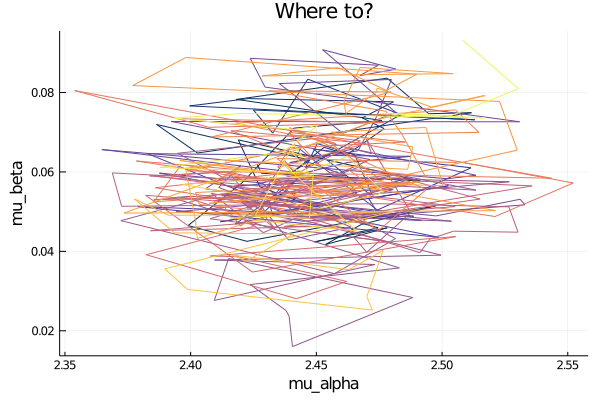

In [132]:

plot([tr[:mu_alpha] for tr in trs5],
    [tr[:mu_beta] for tr in trs5],
    linecolor=[cgrad(:thermal)[i / length(trs5)] for i in 1:length(trs5)],
    xlabel="mu_alpha",
    ylabel = "mu_beta",
    title="Where to?",
    legend=false)

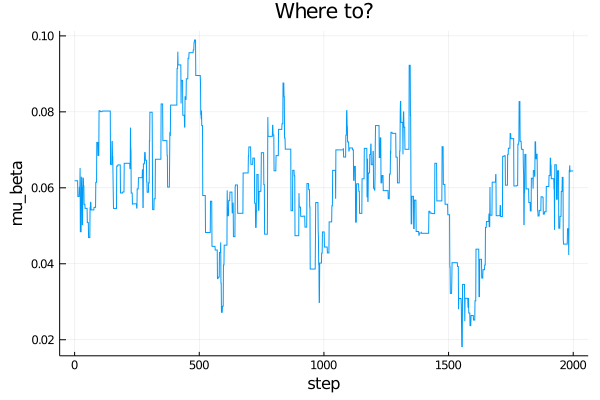

In [82]:
plot(0:VIZ_FRAMES,
    [tr[:mu_beta] for tr in trs5],
    color=[i for i in 1:length(trs5)] ,
    palette=cgrad(:blues),
    xlabel="step",
    ylabel = "mu_beta",
    title="Where to?",
    legend=false)

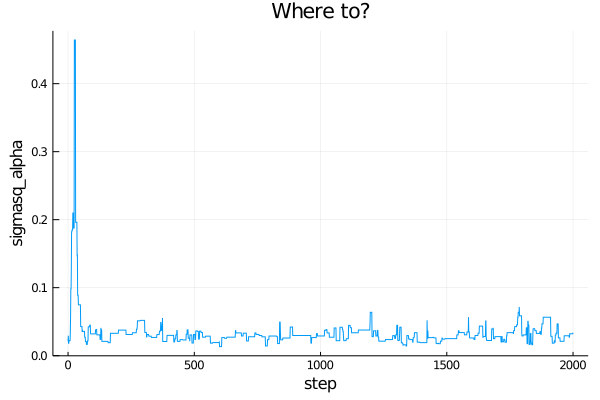

In [85]:
plotsteps = length(trs5)
plot(0:plotsteps-1,
    [tr[:sigmasq_alpha] for tr in trs5[1:plotsteps]],
    xlabel="step",
    ylabel = "sigmasq_alpha",
    title="Where to?",
    legend=false)

In [79]:
trs5[end][:sigmasq_alpha]

2.2299769043489257

In [130]:
cgrad(:thermal)[0.]

In [53]:

Profile.clear()
VIZ_INTERVAL = 1
VIZ_FRAMES = 800
observations = make_constraints(ys)

trs3= Profile.@profile mcmc_inference(xs, observations, VIZ_INTERVAL * VIZ_FRAMES, block_mh_d, deferredRatsModel)
printKeyVals(trs3[1])
println("")
printKeyVals(trs3[end])
;

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)), (1.0, UnrealizedNormalIndyLeafValue(6.206916887548323, 6.184399804905268, 6.206916887548323, 3))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2681888482639139, Inf, NaN, 3)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNod

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNod

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNod

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNod

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNod

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNod

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNod

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNod

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNod

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 4.4535403486598835, 6.232855522934393, 5))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 5)
│   node = UnrealizedNormalNod

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(-7.0, UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)), (1.0, UnrealizedNormalIndyLeafValue(6.232855522934393, 5.246540206806767, 6.232855522934393, 7))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2704432726536077, Inf, NaN, 7)
│   node = UnrealizedNormalNodeVa

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValu

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValu

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValu

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValu

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValu

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValu

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValu

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValu

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValu

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)), (1.0, UnrealizedNormalIndyLeafValue(6.132121322947309, 4.877235333520137, 6.132121322947309, 9))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.2648413618629792, Inf, NaN, 9)
│   node = UnrealizedNormalNodeValu

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNo

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNo

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNo

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNo

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(0.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNo

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(7.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(7.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNo

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(7.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(7.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNo

┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(7.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(7.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNo

Excessive output truncated after 524916 bytes.┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(7.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129
┌ Debug: bad leaf?
│   l = UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11)
│   node = UnrealizedNormalNodeValue(0.0, Tuple{Float64,UnrealizedNormalLeafValue}[(7.0, UnrealizedNormalIndyLeafValue(-1.269264850740126, Inf, NaN, 11)), (1.0, UnrealizedNormalIndyLeafValue(5.995772670379809, 6.6638944766709365, 5.995772670379809, 11))])
└ @ Main /Users/chema/github/Gen/examples/stan/bugsv1/unrealizedNormals.jl:129


In [34]:

VIZ_INTERVAL = 1
VIZ_FRAMES = 800
trs4=  mcmc_inference(xs, c, VIZ_INTERVAL * VIZ_FRAMES, block_mh_drift_just_mus, deferredRatsModel) #don't bother to Profile.@profile
printKeyVals(trs4[1])
println("")
printKeyVals(trs4[end])
;

mu_alpha: 2.4265333333333334, mu_beta: 0.06185714285714284
sigma_y: 0.07331553576995054, sigma_α: 0.14505165152177826, sigma_β: 0.005783570119018571

mu_alpha: 2.363915530866041, mu_beta: 0.06494243123999582
sigma_y: 0.07331553576995054, sigma_α: 0.14505165152177826, sigma_β: 0.005783570119018571


In [35]:
_, w1 = generate(deferredRatsModel, (xs, N), c)

tr_end = trs4[end]
c2 = make_constraints(ys)
c2[:sigmasq_beta] = c[:sigmasq_beta]
c2[:sigmasq_alpha] = c[:sigmasq_alpha]
c2[:sigmasq_y] = c[:sigmasq_y]
c2[:mu_alpha] = tr_end[:mu_alpha]
c2[:mu_beta] = tr_end[:mu_beta]

_, w2 = generate(deferredRatsModel, (xs, N), c2)
_, w3 = generate(deferredRatsModel, (xs, N), get_choices(tr_end))

(w1, w2, w3)

(-2891.379926564975, -2885.4277518861445, -2885.4277518861445)

In [30]:
@debug "hi" 4 5 6
@warn "bye" 4 5 6

┌ Warning: bye
│   4 = 4
│   5 = 5
│   6 = 6
└ @ Main In[30]:2


In [59]:
length(trs5)

801

In [48]:
get_choices(tr_end)

│
├── :sigmasq_beta : 3.3449683321604484e-5
│
├── :sigmasq_y : 0.0053751677852348955
│
├── :mu_beta : 0.7065834500007437
│
├── :mu_alpha : 16.838246644262252
│
├── :sigmasq_alpha : 0.021039981609195398
│
└── :data
    │
    ├── 18
    │   │
    │   ├── "y3" : 2.43
    │   │
    │   ├── :alpha : UnrealizedNormalIndyLeafValue(2.4265333333333334, 0.0007945059821763276, 2.4040006760431583)
    │   │
    │   ├── :beta : UnrealizedNormalIndyLeafValue(0.06185714285714284, 8.025070133956219e-5, 0.05742942407566575)
    │   │
    │   ├── "y1" : 1.56
    │   │
    │   ├── "y4" : 2.83
    │   │
    │   ├── "y2" : 2.03
    │   │
    │   └── "y5" : 3.17
    │
    ├── 30
    │   │
    │   ├── "y3" : 2.44
    │   │
    │   ├── :alpha : UnrealizedNormalIndyLeafValue(2.4265333333333334, 0.0007945059821763276, 2.4140003760239996)
    │   │
    │   ├── :beta : UnrealizedNormalIndyLeafValue(0.06185714285714284, 8.025070133956219e-5, 0.06114299466658204)
    │   │
    │   ├── "y1" : 1.53
    │   │
    │   

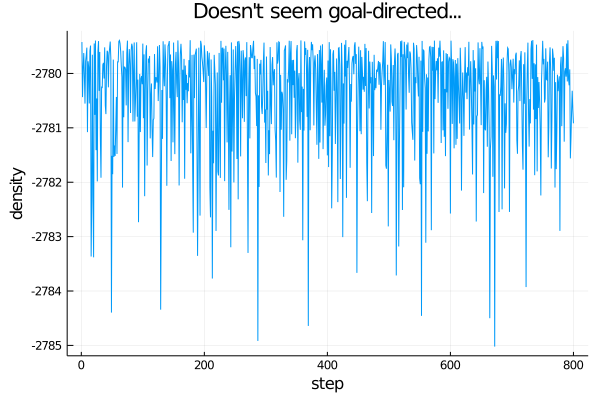

In [45]:
plot([tr[:mu_alpha] for tr in trs4],
    [tr[:mu_beta] for tr in trs4],
    xlabel="mu_alpha",
    ylabel = "mu_beta",
    title="Let's explore the prior!",
    legend=false)

function eval_density_at(tr)
    _, w = generate(deferredRatsModel, (xs, N), get_choices(tr))
    w
end

s = 800
plot(1:s,
    [eval_density_at(tr) for tr in trs4[1:s]],
    xlabel="step",
    ylabel = "density",
    title="Doesn't seem goal-directed...",
    legend=false)

In [392]:
c = make_constraints(ys)
alphahats = mean(ys,dims=2)
alphahat = mean(alphahats)
betahats = [xcs\ys[r,:] for r in 1:N]
betahat = mean(betahats)
c[:mu_alpha] = alphahat + 0.0
c[:mu_beta] = betahat - 0.0

c[:sigmasq_beta] = var(betahats) #* 2.1603 #is better???
c[:sigmasq_alpha] = var(alphahats) #* 20.
c[:sigmasq_y] = var(transpose(xcs) .* betahat .+ alphahats .- ys)#, corrected=false)

compareModels(deferredRatsModel, ratsModel, (xs, N), c, (:data => 1 => :beta))

┌ Warning: with
│   w = -1234.90218783787
│   w2 = -1234.5695654450635
│   m = 0.061020764317851924
│   (tr[locus]).currentMean = 0.0611165449457375
│   vv = 1.0780883979714952e-5
│   (tr[locus]).currentCondSD ^ 2 = 1.0682108486012647e-5
└ @ Main In[382]:7


y 1.0
z 1.0
z2 1.0
y2 1.0


In [400]:
mean([1,2], AnalyticWeights([1,2]))

1.6666666666666667

In [403]:
1 < 2 < 3

true

In [ ]:
function block_mh(tr,N,selection)
    (tr, _) = mh(tr, select(:mu_alpha, :mu_beta))
    (tr, _) = mh(tr, select(:sigmasq_alpha, :sigmasq_beta, :sigmasq_y))

    for n in 1:N
        (tr, _) = mh(tr, select(:data => n => :y,
                                :data => n => :alpha,:data => n => :beta))
    end
    tr
end
;

In [ ]:
function simple_hmc(tr,N,selection)
    (tr, _) = hmc(tr, selection)
    tr
end
;

In [ ]:
VIZ_INTERVAL = 2
VIZ_FRAMES = 10
observations = make_constraints(ys)
trs= mcmc_inference(xs, observations, VIZ_INTERVAL * VIZ_FRAMES, block_mh)
tr = trs[end]
get_choices(tr)
;

In [ ]:
print("mu_alpha: $(tr[:mu_alpha]), mu_beta: $(tr[:mu_beta]), sigma_y: $(sqrt(tr[:sigmasq_y]))")

In [ ]:

visualize_rats(tr,make_axes()[2])

In [ ]:
display_animation("rats_mh", make_axes,
    (ax)->visualize_rats(trs[1],ax),
    (ax,i)->visualize_rats(trs[1+i*VIZ_INTERVAL],ax),
    VIZ_FRAMES)

In [ ]:
VIZ_INTERVAL = 2
VIZ_FRAMES = 10
observations = make_constraints(ys)
trs2= mcmc_inference(xs, observations, VIZ_INTERVAL * VIZ_FRAMES, simple_hmc)
tr2 = trs2[end]
get_choices(tr2)
;

In [ ]:
print("mu_alpha: $(tr2[:mu_alpha]), mu_beta: $(tr2[:mu_beta]), sigma_y: $(sqrt(tr2[:sigmasq_y]))\n")

In [ ]:
if false
    display_animation("rats_hmc", make_axes,
        (ax)->visualize_rats(trs[1],ax),
        (ax,i)->visualize_rats(trs[1+i*VIZ_INTERVAL],ax),
        VIZ_FRAMES)
end

In [ ]:
Profile.clear()


VIZ_INTERVAL = 1
VIZ_FRAMES = 20
observations = make_constraints(ys)
trs3= Profile.@profile mcmc_inference(xs, observations, VIZ_INTERVAL * VIZ_FRAMES, (tr, N, selection)->my_nuts(tr, selection, model_transformations))
tr3 = trs3[end]
print("mu_alpha: $(tr3[:mu_alpha]), mu_beta: $(tr3[:mu_beta]), sigma_y: $(sqrt(tr3[:sigmasq_y]))\n")
;

In [ ]:
ProfileView.view()

In [ ]:
open("profile.txt", "w") do s
    Profile.print(IOContext(s, :displaysize => (24, 500)))
end

In [ ]:
display_animation("rats_nuts", make_axes,
    (ax)->visualize_rats(trs3[1],ax),
    (ax,i)->visualize_rats(trs3[1+i*VIZ_INTERVAL],ax),
    VIZ_FRAMES,200)

The below is just a sketch of how I think "semi-automatic conjugacy" might work. It's not working code, yet.

In [ ]:
l = [(4,6)]
for (a, (b,c)) in enumerate(l)
    @warn "hi" a b c
end